#Biometric Text Analysis on Twitter Dataset using Apache Spark and H2O Machine Learning Framework

- Youssef Nakhla
- Zeina Kishk
- Jana Al Morsy
- Hanya Zamir

##Dependencies

In [ ]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [ ]:
!pip install pyspark

In [ ]:
# Install required packages
!pip install -q nltk spacy emoji
!python -m nltk.downloader punkt stopwords
!python -m spacy download en_core_web_sm

In [ ]:
!pip install scikit-learn

In [ ]:
# === Core Python Libraries ===
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# === NLP & Text Processing ===
import nltk
import spacy
import emoji
from nltk.corpus import stopwords

# === PySpark ===
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType, IntegerType, MapType, StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.functions import vector_to_array

# === Imbalanced Data Handling ===
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# === Scikit-learn ===
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# === H2O.ai ===
import h2o
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import (
    H2OXGBoostEstimator,
    H2ORandomForestEstimator,
    H2OKMeansEstimator,
    H2OGeneralizedLinearEstimator,
    H2ODeepLearningEstimator
)


##Loading Data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

file_path = os.path.join(path, "training.1600000.processed.noemoticon.csv")

In [ ]:
import pandas as pd

file_path = "/home/datasciencef24-yc/Downloads/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(file_path, encoding="latin-1", header=None)


##Data Preprocessing

Dropping columns and renaming the 'target' variable

In [ ]:
df.columns = ["sentiment", "ids", "date", "flag", "user", "text"]
df.drop(["date","flag", "ids"], axis=1, inplace=True)

df.head()

Filtering out users with more than 5 tweets

In [ ]:
# 1. Count tweets per user
tweet_counts = df['user'].value_counts()

# 2. Identify users with more than 1 tweet
users_with_multiple_tweets = tweet_counts[tweet_counts > 5].index

# 3. Filter original DataFrame to keep only those users
df_filtered = df[df['user'].isin(users_with_multiple_tweets)]

# 4. Optional: Reset index
df_filtered = df_filtered.reset_index(drop=True)

# 5. Preview result
print(f"Original dataset shape: {df.shape}")
print(f"Filtered dataset shape: {df_filtered.shape}")

df=df_filtered


Bot Detection

In [ ]:
import re

# 1. Function to clean tweet text
def normalize_text(text):
    text = re.sub(r'@\w+', '@user', text)  # Replace mentions
    text = re.sub(r'http\S+', '', text)   # Remove URLs
    text = re.sub(r'\s+', ' ', text)      # Normalize whitespace
    return text.strip().lower()

# 2. Apply to your DataFrame
df['normalized_text'] = df['text'].apply(normalize_text)

# 3. Group by user and normalized text
text_counts = df.groupby(['user', 'normalized_text']).size().reset_index(name='count')

# 4. Filter for repeated texts per user
repeated_texts = text_counts[text_counts['count'] > 1]

# 5. Count how many users have repeated texts
repeating_users = repeated_texts['user'].value_counts()

print(f"Users posting repeated base tweets: {len(repeating_users)}")

# 6. Optionally: flag them
bot_suspects = set(repeating_users.index)
df['is_suspected_bot'] = df['user'].isin(bot_suspects)


In [ ]:
# 1. Drop rows where user is in the bot_suspects set
df_cleaned = df[~df['user'].isin(bot_suspects)]

# 2. Optional: Reset index
df_cleaned = df_cleaned.reset_index(drop=True)

# 3. Preview the result
print(f"Original number of tweets: {df.shape[0]}")
print(f"Remaining tweets after dropping suspected bots: {df_cleaned.shape[0]}")

df=df_cleaned
df.drop('normalized_text', axis=1, inplace=True)
df.drop('is_suspected_bot', axis=1, inplace=True)
df.head()


Cleaning text

In [ ]:
import re
def remove_mentions(text):
    """Remove @mentions from the text."""
    return re.sub(r'@\w+', '', text)

def remove_urls(text):
    """Remove http/https URLs from the text."""
    return re.sub(r'http\S+|www\S+', '', text)

def remove_extra_whitespace(text):
    """Remove leading/trailing/multiple spaces."""
    return re.sub(r'\s+', ' ', text).strip()

# def to_lowercase(text):
#     """Convert text to lowercase."""
#     return text.lower()

def remove_non_ascii(text):
    """Remove non-ASCII characters (optional)."""
    return text.encode('ascii', errors='ignore').decode()

def preprocess_text(text):
    """Apply all preprocessing steps."""
    text = remove_mentions(text)
    text = remove_urls(text)
    text = remove_extra_whitespace(text)
    # text = to_lowercase(text)
    # Uncomment the next line only if needed
    # text = remove_non_ascii(text)
    return text


In [ ]:
# Apply the preprocessing function to each row in the 'text' column
df['clean_text'] = df['text'].apply(preprocess_text)

# Preview the result
df[['text', 'clean_text']].head()

##Feature Extraction (Spark)

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SparklingWaterApp").getOrCreate()

In [ ]:
from pysparkling import *
sc = spark.sparkContext

In [ ]:
# Start Spark session if not already started
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TextFeatureExtraction").getOrCreate()

In [ ]:
# Convert pandas DataFrame to Spark DataFrame
df_spark = spark.createDataFrame(df)

In [ ]:
sc

In [ ]:
# Load required NLP resources
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

nlp = spacy.load('en_core_web_sm')

# Define slang words set
slang_words = {
    'lol', 'brb', 'idk', 'lmao', 'omg', 'smh', 'tbh', 'fyi', 'btw', 'imo',
    'thx', 'pls', 'plz', 'rofl', 'yolo', 'jk', 'np', 'afaik', 'nvm', 'ikr'
}

# Lexical Features
@udf(FloatType())
def avg_word_length(text):
    words = text.split()
    return float(np.mean([len(word) for word in words])) if words else 0.0

@udf(FloatType())
def type_token_ratio(text):
    words = text.split()
    return float(len(set(words)) / len(words)) if words else 0.0

@udf(FloatType())
def capital_word_ratio(text):
    words = text.split()
    return float(sum(1 for w in words if w.isupper()) / len(words)) if words else 0.0

# Structural Features
@udf(IntegerType())
def char_count(text): return len(text)

@udf(IntegerType())
def word_count(text): return len(text.split())

@udf(FloatType())
def avg_sentence_length(text):
    sentences = re.split(r'[.!?]', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    return float(np.mean([len(s.split()) for s in sentences])) if sentences else 0.0

@udf(FloatType())
def capitalization_ratio(text):
    return float(sum(1 for c in text if c.isupper()) / len(text)) if text else 0.0

@udf(IntegerType())
def sentence_count(text):
    return len([s for s in re.split(r'[.!?]', text) if s.strip()])

# Style Features
@udf(FloatType())
def stopword_ratio(text):
    words = text.split()
    return float(sum(1 for w in words if w.lower() in stop_words) / len(words)) if words else 0.0

@udf(IntegerType())
def emoji_count(text): return sum(1 for c in text if c in emoji.EMOJI_DATA)

@udf(IntegerType())
def hashtag_count(text): return text.count('#')

@udf(IntegerType())
def repeated_char_count(text): return len(re.findall(r'(.)\1{2,}', text))

@udf(IntegerType())
def slang_count(text):
    words = text.lower().split()
    return sum(1 for w in words if w in slang_words)

@udf(IntegerType())
def quote_symbol_count(text): return text.count('"') + text.count("'")

@udf(IntegerType())
def symbol_count(text): return sum(1 for c in text if c in {'$', '%', '~', '*', '&', '@'})

@udf(IntegerType())
def multiple_punctuation_count(text): return len(re.findall(r'(!{2,}|\?{2,}|\.{2,})', text))

# Syntactic Features via SpaCy (POS tagging & punctuation)
@udf(MapType(StringType(), FloatType()))
def pos_tag_distribution(text):
    try:
        doc = nlp(text)
        pos_counts = Counter([token.pos_ for token in doc])
        total = sum(pos_counts.values())
        return {
            f'pos_{tag.lower()}': float(pos_counts.get(tag, 0) / total) if total > 0 else 0.0
            for tag in ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON']
        }
    except:
        return {}

@udf(MapType(StringType(), FloatType()))
def punctuation_usage(text):
    try:
        return {
            f'punct_{p}': float(text.count(p) / len(text)) if len(text) > 0 else 0.0
            for p in punctuation_marks
        }
    except:
        return {}

df_features = df_spark \
    .withColumn("avg_word_len", avg_word_length(col("text"))) \
    .withColumn("type_token_ratio", type_token_ratio(col("text"))) \
    .withColumn("capital_word_ratio", capital_word_ratio(col("text"))) \
    .withColumn("char_count", char_count(col("text"))) \
    .withColumn("word_count", word_count(col("text"))) \
    .withColumn("avg_sentence_len", avg_sentence_length(col("text"))) \
    .withColumn("capitalization_ratio", capitalization_ratio(col("text"))) \
    .withColumn("sentence_count", sentence_count(col("text"))) \
    .withColumn("stopword_ratio", stopword_ratio(col("text"))) \
    .withColumn("emoji_count", emoji_count(col("text"))) \
    .withColumn("hashtag_count", hashtag_count(col("text"))) \
    .withColumn("repeated_char_count", repeated_char_count(col("text"))) \
    .withColumn("slang_count", slang_count(col("text"))) \
    .withColumn("quote_symbol_count", quote_symbol_count(col("text"))) \
    .withColumn("symbol_count", symbol_count(col("text"))) \
    .withColumn("multiple_punct_count", multiple_punctuation_count(col("text"))) \
    .withColumn("pos_distribution", pos_tag_distribution(col("text"))) \
    .withColumn("punctuation_usage", punctuation_usage(col("text")))


In [ ]:
# 1. Tokenize text
tokenizer = Tokenizer(inputCol="text", outputCol="words")
df_tokenized = tokenizer.transform(df_features)

# 2. Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_filtered = remover.transform(df_tokenized)

# 3. Generate TF features
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=300)
df_tf = hashing_tf.transform(df_filtered)

# 4. Fit IDF model and transform
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(df_tf)
df_final = idf_model.transform(df_tf)

# 5. Convert sparse TF-IDF vector to array
df_with_array = df_final.withColumn("tfidf_array", vector_to_array("tfidf_features"))

# 6. Generate individual TF-IDF column names
tfidf_col_names = [f"tfidf_{i}" for i in range(300)]

# 7. Split TF-IDF array into individual columns
for i, name in enumerate(tfidf_col_names):
    df_with_array = df_with_array.withColumn(name, col("tfidf_array")[i])

# 8. Drop intermediate vector/array columns
df_flat = df_with_array.drop("raw_features", "tfidf_features", "tfidf_array", "words", "filtered_words")



In [ ]:
df_flat = df_flat.drop('text', 'clean_text', 'words', 'filtered')
df_flat.show()

In [ ]:
# POS tags
pos_tags = ['noun', 'verb', 'adj', 'adv', 'pron']
for tag in pos_tags:
    df_flat = df_flat.withColumn(f'pos_{tag}', col("pos_distribution").getItem(f'pos_{tag}'))

# Common punctuations
punct_marks = ['.', ',', '?', '!', '"', "'"]
for mark in punct_marks:
    col_name = f'punct_{mark}' if mark.isalnum() else f'punct_{mark.replace(".", "dot")}'
    df_flat = df_flat.withColumn(col_name, col("punctuation_usage").getItem(mark))

# Now drop the maps
df_flat = df_flat.drop("pos_distribution", "punctuation_usage")


In [ ]:
df_flat = df_flat.drop( 'punct_.', 'punct_,', 'punct_?', 'punct_!', 'punct_"', "punct_'")

df_flat.show()

In [ ]:
output_dir = "/home/datasciencef24-yc/Downloads/df_flat_csv"

df_flat.write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(output_dir)

print(f"DataFrame saved as partitioned CSV files in: {output_dir}")


In [ ]:
spark.stop()

Shifting to pandas to combine the file

In [ ]:
# Define the directory
csv_dir = "/home/datasciencef24-yc/Downloads/df_flat_csv/"

# List all CSV files in the directory
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

# Read and concatenate
df_list = [pd.read_csv(os.path.join(csv_dir, file)) for file in csv_files]
df_combined = pd.concat(df_list, ignore_index=True)

# Preview
print(f"Total files read: {len(csv_files)}")
print(f"Combined shape: {df_combined.shape}")
df_combined.head()


In [ ]:
df_combined.drop('punct_dot', axis=1, inplace=True)

In [ ]:
output_path = "/home/datasciencef24-yc/Downloads/df_combined_clean.csv"
df_combined.to_csv(output_path, index=False)

print(f"✅ DataFrame saved to: {output_path}")

##Handling Class Imbalance

In [ ]:
file_path = "/content/drive/MyDrive/Big Data Project/df_combined_clean.csv"
df = pd.read_csv(file_path)


In [ ]:
# 1. Choose user X
user_X = "SallytheShizzle"

# 2. Label the data
df["label"] = df["user"].apply(lambda u: 1 if u == user_X else 0)

In [ ]:
df["label"].value_counts()

,count
label,
0,567539
1,281


Extracting the Unseen data and excluding it

In [ ]:
# 3. Sample 10 positive + 10 negative for unseen set
pos_sample = df[df["label"] == 1].sample(n=10, random_state=42)
neg_sample = df[df["label"] == 0].sample(n=20, random_state=42)

unseen_df = pd.concat([pos_sample, neg_sample], ignore_index=True)

output_path = "/content/drive/MyDrive/Big Data Project/df_unseen.csv"
unseen_df.to_csv(output_path, index=False)

print(f"✅ DataFrame saved to: {output_path}")


# 4. Remove unseen rows from main df (by index to avoid collision)
df_filtered = df.drop(unseen_df.index)

✅ DataFrame saved to: /content/drive/MyDrive/Big Data Project/df_unseen.csv


In [ ]:
# Separate features and label
X = df.drop(columns=['label'])
y = df['label']
user_col = df['user']  # save user info

# Keep only numeric features for resampling
X_numeric = X.select_dtypes(include='number')

# Step 1: Undersample class 0 to 250,000
undersample = RandomUnderSampler(sampling_strategy={0: 250000, 1: y.sum()}, random_state=42)
X_under, y_under = undersample.fit_resample(X_numeric, y)

# Get user column after undersampling
user_under = user_col.iloc[undersample.sample_indices_].reset_index(drop=True)

# Step 2: SMOTE class 1 to 250,000
smote = SMOTE(sampling_strategy={1: 250000}, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_under, y_under)

# Fix the user column after SMOTE
# First get class 0 and class 1 user segments from undersampled data
user_under = user_under.reset_index(drop=True)
y_under = pd.Series(y_under).reset_index(drop=True)

user_0 = user_under[y_under == 0].reset_index(drop=True)
user_1 = user_under[y_under == 1].reset_index(drop=True)

# Expand user_1 to match SMOTE upsampling
user_1_balanced = pd.Series(
    np.repeat(user_1.values, 250000 // len(user_1))
).reset_index(drop=True)

# Combine user columns
user_balanced = pd.concat([user_0, user_1_balanced], ignore_index=True)

# Create final balanced DataFrame
df_balanced = pd.DataFrame(X_balanced)
df_balanced['user'] = user_balanced
df_balanced['label'] = y_balanced

# Confirm balance
print("Balanced label counts:")
print(df_balanced['label'].value_counts())


Balanced label counts:
label
0    250000
1    250000
Name: count, dtype: int64


<ipython-input-6-22859ea5b658>:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_balanced['user'] = user_balanced
<ipython-input-6-22859ea5b658>:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_balanced['label'] = y_balanced


In [ ]:
df_balanced.to_csv("/content/drive/MyDrive/Big Data Project/df_balanced.csv", index=False)

##H2O

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 32 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,"21 days, 23 hours and 29 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_8d9m5i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.765 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


###Loading the Data

In [ ]:
# ✅ Load and split data
def load_data_to_h2o(path):
    hf = h2o.import_file(path)
    hf['label'] = hf['label'].asfactor()
    features = [col for col in hf.columns if col not in ['label', 'user']]
    target = 'label'
    train, test = hf.split_frame(ratios=[0.8], seed=42)
    return hf, train, test, features, target

In [ ]:
hf, train, test, features, target = load_data_to_h2o("/content/drive/MyDrive/Big Data Project/df_balanced.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### Modelling

In [ ]:
def train_logistic_regression(train, features, target):
    from h2o.estimators.glm import H2OGeneralizedLinearEstimator
    model = H2OGeneralizedLinearEstimator(family='binomial', lambda_=0, standardize=True, solver='IRLSM', seed=42)
    model.train(x=features, y=target, training_frame=train)
    return model

In [ ]:
def train_svm_like(train, features, target):
    from h2o.estimators.deeplearning import H2ODeepLearningEstimator
    model = H2ODeepLearningEstimator(hidden=[1], activation='Tanh', epochs=20,
                                     train_samples_per_iteration=-1, reproducible=True, seed=42)
    model.train(x=features, y=target, training_frame=train)
    return model


In [ ]:
def train_xgboost(train, features, target):
    from h2o.estimators import H2OXGBoostEstimator

    xgb = H2OXGBoostEstimator(
        ntrees=200,
        max_depth=5,
        learn_rate=0.05,
        subsample=0.8,
        col_sample_rate=0.8,
        seed=42
    )
    xgb.train(x=features, y=target, training_frame=train)
    return xgb


In [ ]:
def train_random_forest(train, features, target):
    from h2o.estimators import H2ORandomForestEstimator

    rf = H2ORandomForestEstimator(
        ntrees=100,
        max_depth=10,
        sample_rate=0.8,
        col_sample_rate_per_tree=0.8,
        seed=42
    )
    rf.train(x=features, y=target, training_frame=train)
    return rf


In [ ]:
# 2. Train models
log_reg = train_logistic_regression(train, features, target)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [ ]:
svm_like = train_svm_like(train, features, target)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


In [ ]:
xgb = train_xgboost(train, features, target)

xgboost Model Build progress: |

/usr/local/lib/python3.11/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Using user-provided parameter subsample instead of sample_rate."
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████| (done) 100%


In [ ]:
rf = train_random_forest(train, features, target)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


### Evaluating Models

In [ ]:
def evaluate_model(model, test_frame, model_name="Model"):
    print(f"\n\n===== {model_name} Evaluation =====")
    predictions = model.predict(test_frame).as_data_frame()['predict'].astype(int)
    true_labels = test_frame['label'].as_data_frame()['label'].astype(int)

    cm = confusion_matrix(true_labels, predictions)
    cr = classification_report(true_labels, predictions, digits=2)

    # Print classification report
    print("\nClassification Report:\n", cr)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



===== Logistic Regression Evaluation =====
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"



Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.93     49866
           1       0.90      0.97      0.94     49898

    accuracy                           0.93     99764
   macro avg       0.94      0.93      0.93     99764
weighted avg       0.94      0.93      0.93     99764



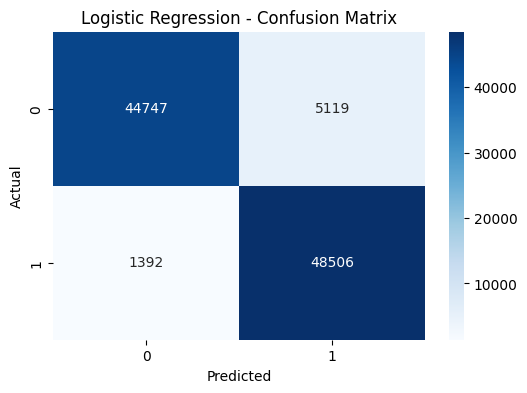

In [ ]:
# 3. Evaluate on test set
evaluate_model(log_reg, test, "Logistic Regression")



===== SVM-like Evaluation =====
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"



Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91     49866
           1       0.87      0.97      0.92     49898

    accuracy                           0.91     99764
   macro avg       0.92      0.91      0.91     99764
weighted avg       0.92      0.91      0.91     99764



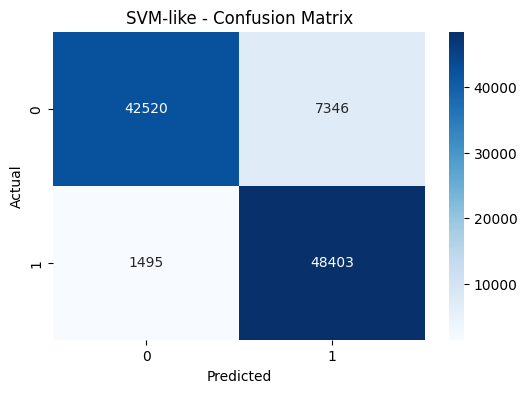

In [ ]:
evaluate_model(svm_like, test, "SVM-like")



===== XGBoost Evaluation =====
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     49866
           1       1.00      1.00      1.00     49898

    accuracy                           1.00     99764
   macro avg       1.00      1.00      1.00     99764
weighted avg       1.00      1.00      1.00     99764



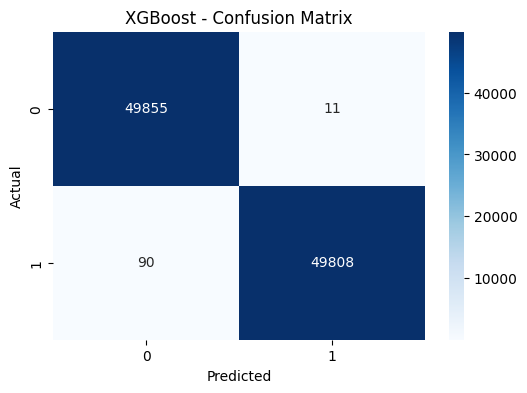

In [ ]:
evaluate_model(xgb, test, "XGBoost")



===== Random Forest Evaluation =====
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"



Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     49866
           1       0.98      0.97      0.97     49898

    accuracy                           0.98     99764
   macro avg       0.98      0.98      0.98     99764
weighted avg       0.98      0.98      0.98     99764



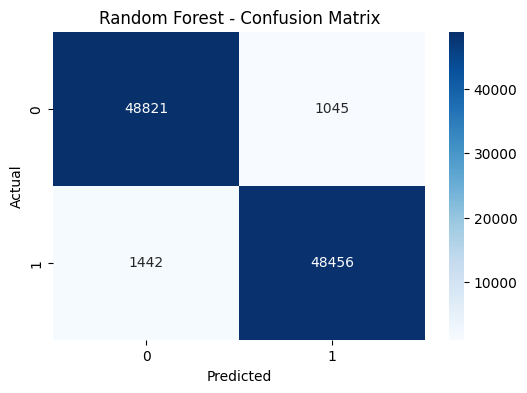

In [ ]:
evaluate_model(rf, test, "Random Forest")

### Unseen Data

In [ ]:
def evaluate_on_unseen(model, model_name="Model", unseen_path="/content/drive/MyDrive/Big Data Project/df_unseen.csv"):
    hf_unseen = h2o.import_file(unseen_path)
    if 'label' in hf_unseen.columns:
        hf_unseen['label'] = hf_unseen['label'].asfactor()

    evaluate_model(model, hf_unseen, model_name)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


===== Logistic Regression Evaluation =====
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


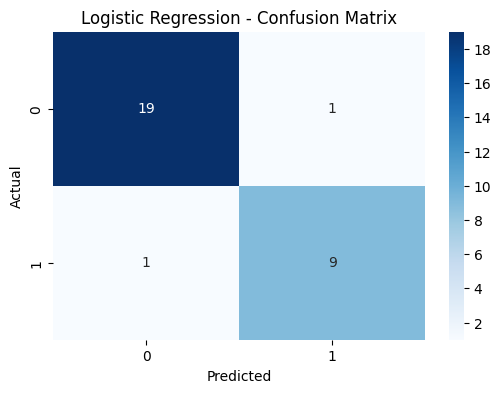

In [ ]:
# 4. Evaluate on unseen
evaluate_on_unseen(log_reg, "Logistic Regression")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


===== SVM-like Evaluation =====
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        20
           1       0.80      0.80      0.80        10

    accuracy                           0.87        30
   macro avg       0.85      0.85      0.85        30
weighted avg       0.87      0.87      0.87        30



/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


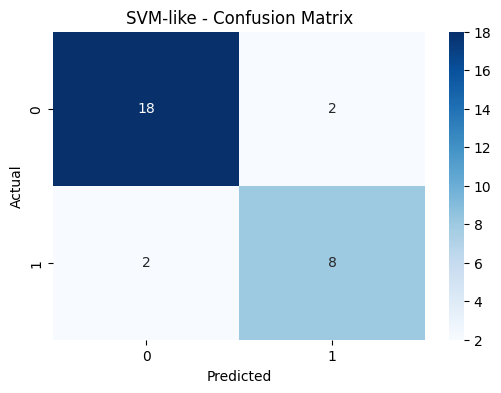

In [ ]:
evaluate_on_unseen(svm_like, "SVM-like")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


===== XGBoost Evaluation =====
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%

Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83        20
           1       1.00      0.20      0.33        10

    accuracy                           0.73        30
   macro avg       0.86      0.60      0.58        30
weighted avg       0.81      0.73      0.67        30



/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


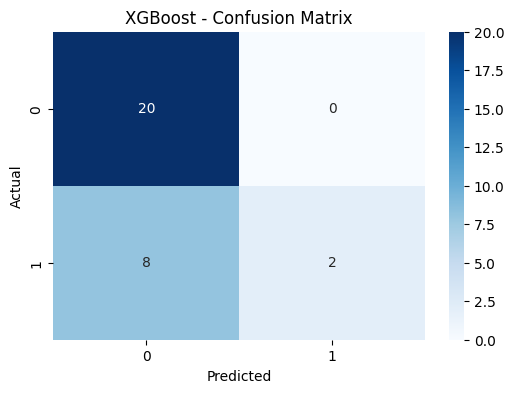

In [ ]:
evaluate_on_unseen(xgb, "XGBoost")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


===== Random Forest Evaluation =====
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.83      1.00      0.91        10

    accuracy                           0.93        30
   macro avg       0.92      0.95      0.93        30
weighted avg       0.94      0.93      0.93        30



/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


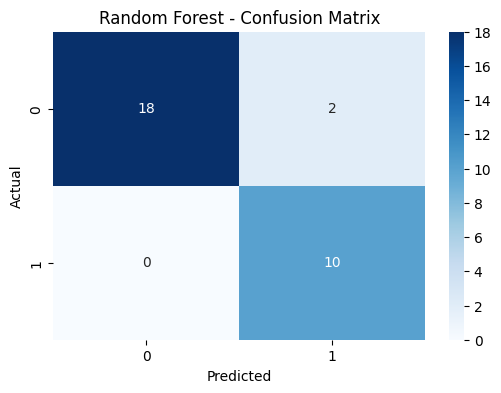

In [ ]:
evaluate_on_unseen(rf, "Random Forest")